In [4]:
import os
import json
import pandas as pd
from pathlib import Path

# Set root directory (user will upload zip, we will extract and re-run)
root_dir = Path("data_need")  # This must match extracted folder

# Initialize list to store merged entries
final_entries = []

# Loop over each DOI folder
for folder in root_dir.iterdir():
    if folder.is_dir():
        doi_name = folder.name
        thermo_file = folder / "t_4.1_mini.json"
        structure_file = folder / "s_4.1_mini.json"

        try:
            with open(thermo_file) as f:
                thermo_data = json.load(f)
        except:
            thermo_data = {"materials": []}

        try:
            with open(structure_file) as f:
                structure_data = json.load(f)
        except:
            structure_data = {"materials": []}

        # Build structural lookup
        structural_map = {
            s["name"]: s for s in structure_data.get("materials", []) if s.get("name")
        }

        matched_names = set()
        for t in thermo_data.get("materials", []):
            name = t.get("name")
            s = structural_map.get(name, {})
            matched_names.add(name)
            final_entries.append({"doi": doi_name, **t, **s})

        unmatched_structural = set(structural_map.keys()) - matched_names
        '''for name in unmatched_structural:
            s = structural_map[name]
            final_entries.append({"doi": doi_name, **s})'''

df = pd.json_normalize(final_entries)
csv_path = "gpt_4.1_mini_thermo_structural.csv"
df.to_csv(csv_path, index=False)

In [37]:
import pandas as pd
from pathlib import Path
df=pd.read_csv("cleaned_gemini_2.0_flash_thermo_structural.csv")

In [38]:
df

,doi,name,zt_values,electrical_conductivity,electrical_resistivity,seebeck_coefficient,power_factor,thermal_conductivity,compound_type,crystal_structure,lattice_structure,unit,space_group,processing_method,lattice_parameters.a,lattice_parameters.b,lattice_parameters.c,doping.doping_type,doping.dopants,dielectric_constant
0,10.1016_j.actamat.2016.10.077,Mg2Sn0.75Ge0.25,[],[],NaN,[],"[{'PF_value': 54, 'PF_unit': 'μW cm−1 K−2', 'P...",[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,"['Sb', 'Bi', 'Y', 'La', 'Al', 'Zn', 'P']",NaN
1,10.1016_j.actamat.2016.10.077,Mg2Sn0.73Bi0.02Ge0.25,[{'value': 1.4}],[],NaN,[],NaN,[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi'],NaN
2,10.1016_j.actamat.2016.10.077,Mg 2 Sn 0.75 Ge 0.25,[],[],NaN,[],"[{'PF_value': 50, 'PF_unit': 'μW cm −1 K −2', ...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN
3,10.1016_j.actamat.2016.10.077,Mg 2 Si,[],[],NaN,[],"[{'PF_value': 22, 'PF_unit': 'μW cm −1 K −2', ...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n-type,"['Y', 'Sb', 'Al', 'Zn']",NaN
4,10.1016_j.actamat.2016.10.077,Mg 2 Sn 0.75-x Bi x Ge 0.25,[],[],"[{'ρ_value': 7.5, 'ρ_unit': 'μΩ m', 'ρ_Tempera...",[],NaN,[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi'],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,10.1016_j.tsf.2013.04.143,PdS,[],[],"[{'ρ_value': 15000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -100.0}],NaN,[],chalcogenide,tetragonal,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,6.33,NaN,6.63,NaN,[],NaN
215,10.1016_j.tsf.2013.04.143,PdS2,[],[],"[{'ρ_value': 20000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -120.0}],NaN,[],chalcogenide,orthorhombic,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,5.41,5.49,7.45,NaN,[],NaN
216,10.1016_S0022-4596(03)00417-1,Pb0.65Sn0.35Te,[{'value': 0.0012}],[],NaN,[],NaN,[],alloy,NaN,NaN,NaN,NaN,mechanical alloying,NaN,NaN,NaN,NaN,[],NaN
217,10.1016_S0925-8388(02)01002-2,Mo6Te8−xSx,[],[],"[{'ρ_value': 1e-05, 'ρ_unit': 'Ω m', 'ρ_Temper...",[],NaN,[],pseudo-binaries,same as Mo6Te8,hexagonal,NaN,NaN,Polycrystalline samples prepared from stoichio...,NaN,NaN,NaN,NaN,[],NaN


In [39]:
'''import ast

def clean_column(col):
    def clean_entry(entry):
        try:
            # Convert string representation of list/dict to actual list/dict
            data = ast.literal_eval(entry) if isinstance(entry, str) else entry
            # If it's a list with one dict and all values are None, return []
            if isinstance(data, list) and len(data) == 1 and isinstance(data[0], dict):
                if all(v is None for v in data[0].values()):
                    return []
            return data
        except Exception:
            return entry  # If parsing fails, return as is
    return col.apply(clean_entry)'''
import ast

def clean_column(col):
    def clean_entry(entry):
        try:
            data = ast.literal_eval(entry) if isinstance(entry, str) else entry
            if isinstance(data, list) and all(
                isinstance(d, dict) and next(iter(d.values()), None) is None for d in data
            ):
                return []
            return data
        except Exception:
            return entry
    return col.apply(clean_entry)

cols_to_clean = [
    'zt_values',
    'electrical_conductivity',
    'seebeck_coefficient',
    'thermal_conductivity'
]

for col in cols_to_clean:
    df[col] = clean_column(df[col])

In [40]:
df

,doi,name,zt_values,electrical_conductivity,electrical_resistivity,seebeck_coefficient,power_factor,thermal_conductivity,compound_type,crystal_structure,lattice_structure,unit,space_group,processing_method,lattice_parameters.a,lattice_parameters.b,lattice_parameters.c,doping.doping_type,doping.dopants,dielectric_constant
0,10.1016_j.actamat.2016.10.077,Mg2Sn0.75Ge0.25,[],[],NaN,[],"[{'PF_value': 54, 'PF_unit': 'μW cm−1 K−2', 'P...",[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,"['Sb', 'Bi', 'Y', 'La', 'Al', 'Zn', 'P']",NaN
1,10.1016_j.actamat.2016.10.077,Mg2Sn0.73Bi0.02Ge0.25,[{'value': 1.4}],[],NaN,[],NaN,[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi'],NaN
2,10.1016_j.actamat.2016.10.077,Mg 2 Sn 0.75 Ge 0.25,[],[],NaN,[],"[{'PF_value': 50, 'PF_unit': 'μW cm −1 K −2', ...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN
3,10.1016_j.actamat.2016.10.077,Mg 2 Si,[],[],NaN,[],"[{'PF_value': 22, 'PF_unit': 'μW cm −1 K −2', ...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n-type,"['Y', 'Sb', 'Al', 'Zn']",NaN
4,10.1016_j.actamat.2016.10.077,Mg 2 Sn 0.75-x Bi x Ge 0.25,[],[],"[{'ρ_value': 7.5, 'ρ_unit': 'μΩ m', 'ρ_Tempera...",[],NaN,[],NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi'],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,10.1016_j.tsf.2013.04.143,PdS,[],[],"[{'ρ_value': 15000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -100.0}],NaN,[],chalcogenide,tetragonal,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,6.33,NaN,6.63,NaN,[],NaN
215,10.1016_j.tsf.2013.04.143,PdS2,[],[],"[{'ρ_value': 20000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -120.0}],NaN,[],chalcogenide,orthorhombic,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,5.41,5.49,7.45,NaN,[],NaN
216,10.1016_S0022-4596(03)00417-1,Pb0.65Sn0.35Te,[{'value': 0.0012}],[],NaN,[],NaN,[],alloy,NaN,NaN,NaN,NaN,mechanical alloying,NaN,NaN,NaN,NaN,[],NaN
217,10.1016_S0925-8388(02)01002-2,Mo6Te8−xSx,[],[],"[{'ρ_value': 1e-05, 'ρ_unit': 'Ω m', 'ρ_Temper...",[],NaN,[],pseudo-binaries,same as Mo6Te8,hexagonal,NaN,NaN,Polycrystalline samples prepared from stoichio...,NaN,NaN,NaN,NaN,[],NaN


In [41]:
import numpy as np

def empty_or_none_to_nan(col):
    def convert(entry):
        # If entry is an empty list or a list of only None, return np.nan
        if isinstance(entry, list):
            if len(entry) == 0 or all(e is None for e in entry):
                return np.nan
        return entry
    return col.apply(convert)

for col_name in cols_to_clean:
    df[col_name] = empty_or_none_to_nan(df[col_name])

In [32]:
df

,doi,name,zt_values,electrical_conductivity,electrical_resistivity,seebeck_coefficient,power_factor,thermal_conductivity,compound_type,crystal_structure,lattice_structure,unit,space_group,processing_method,lattice_parameters.a,lattice_parameters.b,lattice_parameters.c,doping.doping_type,doping.dopants
0,10.1016_j.actamat.2016.10.077,Mg2Sn0.75Ge0.25,NaN,NaN,NaN,NaN,"[{'PF_value': 54, 'PF_unit': 'μW cm−1 K−2', 'P...",NaN,NaN,cubic anti-fluorite,NaN,NaN,Fm-3m,ball milling and hot pressing,NaN,NaN,NaN,NaN,[]
1,10.1016_j.actamat.2016.10.077,Mg2Sn0.73Bi0.02Ge0.25,[{'value': 1.4}],NaN,NaN,NaN,"[{'PF_value': 54, 'PF_unit': 'μW cm−1 K−2', 'P...",NaN,NaN,cubic anti-fluorite,NaN,NaN,Fm-3m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi']
2,10.1016_j.actamat.2016.10.077,Mg2Si,NaN,NaN,NaN,NaN,"[{'PF_value': 22, 'PF_unit': 'μW cm−1 K−2', 'P...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,10.1016_j.actamat.2016.10.077,"Mg2Si (Sb, Al, Zn doped)",NaN,NaN,NaN,NaN,"[{'PF_value': 33, 'PF_unit': 'μW cm−1 K−2', 'P...",NaN,NaN,NaN,NaN,NaN,NaN,melting followed by spark plasma sintering,NaN,NaN,NaN,NaN,"['Sb', 'Al', 'Zn']"
4,10.1016_j.apenergy.2020.115037,Bi<sub>0.5</sub>Sb<sub>1.5</sub>Te<sub>3</sub>,"[{'value': 1.86}, {'value': 1.7}, {'value': 0.7}]",NaN,NaN,NaN,NaN,NaN,P-type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10.1016_j.tsf.2013.04.143,PdS2,NaN,NaN,"[{'ρ_value': 20000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -120.0}],NaN,NaN,NaN,orthorhombic,NaN,Å,NaN,sulfurization of Pd films,5.41,5.49,7.45,NaN,[]
170,10.1016_S0022-4596(03)00417-1,Pb_{0.7}Sn_{0.3}Te,[{'value': 0.0012}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['Sn']
171,10.1016_S0925-8388(02)01002-2,Mo6Te8,[{'value': 0.015}],NaN,NaN,[{'S_value': 25.0}],"[{'PF_value': 8e-05, 'PF_unit': 'W m⁻¹ K⁻²', '...",NaN,Chevrel phase,NaN,hexagonal,NaN,NaN,Hot-pressing,NaN,NaN,NaN,NaN,[]
172,10.1016_S0925-8388(02)01002-2,Mo3Te4,[{'value': 0.015}],NaN,NaN,[{'S_value': 25.0}],NaN,NaN,Chevrel phase,NaN,NaN,NaN,NaN,Hot-pressing,NaN,NaN,NaN,NaN,[]


In [42]:
df = df.dropna(subset=cols_to_clean, how='all').reset_index(drop=True)

In [43]:
df

,doi,name,zt_values,electrical_conductivity,electrical_resistivity,seebeck_coefficient,power_factor,thermal_conductivity,compound_type,crystal_structure,lattice_structure,unit,space_group,processing_method,lattice_parameters.a,lattice_parameters.b,lattice_parameters.c,doping.doping_type,doping.dopants,dielectric_constant
0,10.1016_j.actamat.2016.10.077,Mg2Sn0.73Bi0.02Ge0.25,[{'value': 1.4}],NaN,NaN,NaN,NaN,NaN,NaN,cubic anti-fluorite,NaN,NaN,F m 3 ̄ m,ball milling and hot pressing,NaN,NaN,NaN,n-type,['Bi'],NaN
1,10.1016_j.apenergy.2020.115037,Bi 0.5 Sb 1.5 Te 3,"[{'value': 1.86}, {'value': 1.7}, {'value': 0.7}]",NaN,NaN,NaN,NaN,NaN,alloy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN
2,10.1016_j.apenergy.2020.115037,Cu 0.01 Bi 2 Te 2.7 Se 0.3,[{'value': 1.1}],NaN,NaN,NaN,NaN,NaN,alloy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p-type,['Cu'],NaN
3,10.1016_j.applthermaleng.2016.05.146,Mg2 − xAgxSi0.4Sn0.6,[{'value': 0.45}],[{'σ_value': 32000.0}],NaN,NaN,"[{'PF_value': 1.03, 'PF_unit': 'mW K −2 m −1',...",NaN,solid solution,anti-fluorite,NaN,NaN,Fm3 m,melt spinning (MS) system followed by spark pl...,NaN,NaN,NaN,p-type,['Ag'],NaN
4,10.1016_j.carbon.2012.10.060,carbon nanowires,[{'value': 10.0}],NaN,NaN,NaN,NaN,NaN,nanowire,diamond,NaN,NaN,NaN,"top-down nanofabrication techniques, chemical ...",NaN,NaN,NaN,n-type and p-type,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,10.1016_j.tsf.2013.04.143,Pd4S,NaN,NaN,"[{'ρ_value': 15.9, 'ρ_unit': 'μΩ cm', 'ρ_Tempe...",[{'S_value': -6.0}],NaN,NaN,chalcogenide,tetragonal,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,5.096,NaN,5.42,NaN,[],NaN
104,10.1016_j.tsf.2013.04.143,PdS,NaN,NaN,"[{'ρ_value': 15000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -100.0}],NaN,NaN,chalcogenide,tetragonal,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,6.330,NaN,6.63,NaN,[],NaN
105,10.1016_j.tsf.2013.04.143,PdS2,NaN,NaN,"[{'ρ_value': 20000, 'ρ_unit': 'μΩ cm', 'ρ_Temp...",[{'S_value': -120.0}],NaN,NaN,chalcogenide,orthorhombic,NaN,Å,NaN,sulfurization of RF sputtered Pd thin films,5.410,5.49,7.45,NaN,[],NaN
106,10.1016_S0022-4596(03)00417-1,Pb0.65Sn0.35Te,[{'value': 0.0012}],NaN,NaN,NaN,NaN,NaN,alloy,NaN,NaN,NaN,NaN,mechanical alloying,NaN,NaN,NaN,NaN,[],NaN


In [44]:
df.to_csv("cleaned_gemini_2.0.csv", index=False)

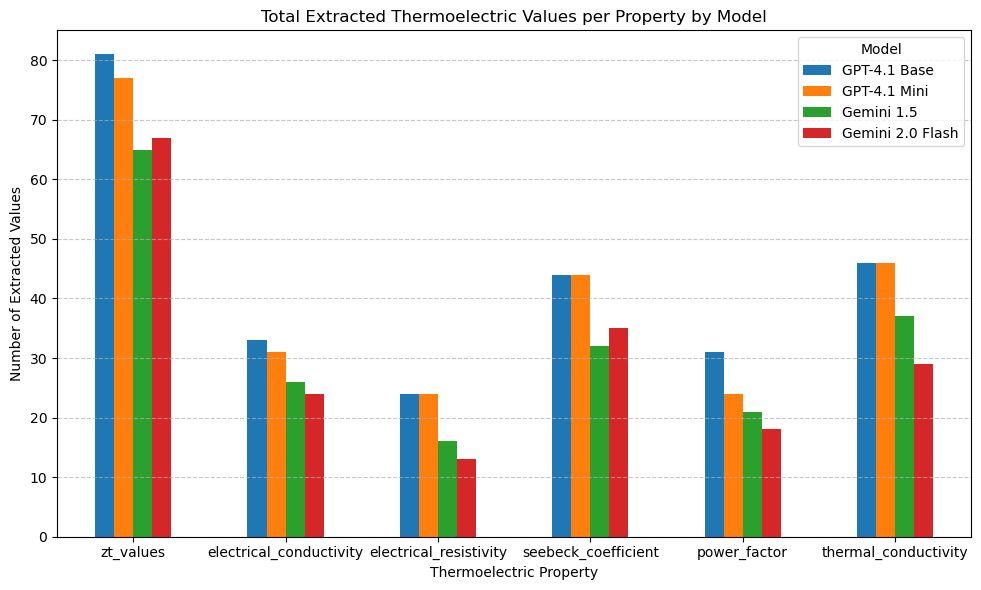

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === Load your CSV files ===
base_df = pd.read_csv("cleaned_gpt_4.1.csv")
flash_df = pd.read_csv("cleaned_gemini_2.0.csv")
gem15_df = pd.read_csv("cleaned_gemini_1.5_pro.csv")
mini_df = pd.read_csv("cleaned_gpt_4.1_mini.csv")

# === Thermoelectric fields to check ===
fields = ["zt_values", "electrical_conductivity","electrical_resistivity", "seebeck_coefficient", "power_factor", "thermal_conductivity"]

# === Count non-empty values per DOI ===
def compute_field_coverage(df, fields):
    summary = defaultdict(lambda: {f: 0 for f in fields})
    for _, row in df.iterrows():
        doi = row["doi"]
        for f in fields:
            val = row.get(f)
            if pd.notna(val) and str(val).strip() not in ["", "[]", "{}", "None"]:
                summary[doi][f] += 1
    return pd.DataFrame.from_dict(summary, orient="index")

# === Compute per-model coverage ===
base_cov = compute_field_coverage(base_df, fields)
flash_cov = compute_field_coverage(flash_df, fields)
gem15_cov = compute_field_coverage(gem15_df, fields)
mini_cov = compute_field_coverage(mini_df, fields)

# === Label and combine ===
base_cov["model"] = "GPT-4.1 Base"
flash_cov["model"] = "Gemini 2.0 Flash"
gem15_cov["model"] = "Gemini 1.5"
mini_cov["model"] = "GPT-4.1 Mini"

combined = pd.concat([base_cov, flash_cov, gem15_cov, mini_cov])
combined.reset_index(inplace=True)
combined.rename(columns={"index": "doi"}, inplace=True)

# === Aggregate and Plot ===
agg = combined.groupby("model")[fields].sum().T  # Transpose so fields are rows
agg.plot(kind="bar", figsize=(10, 6), rot=0)

plt.title("Total Extracted Thermoelectric Values per Property by Model")
plt.ylabel("Number of Extracted Values")
plt.xlabel("Thermoelectric Property")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="Model")
plt.show()


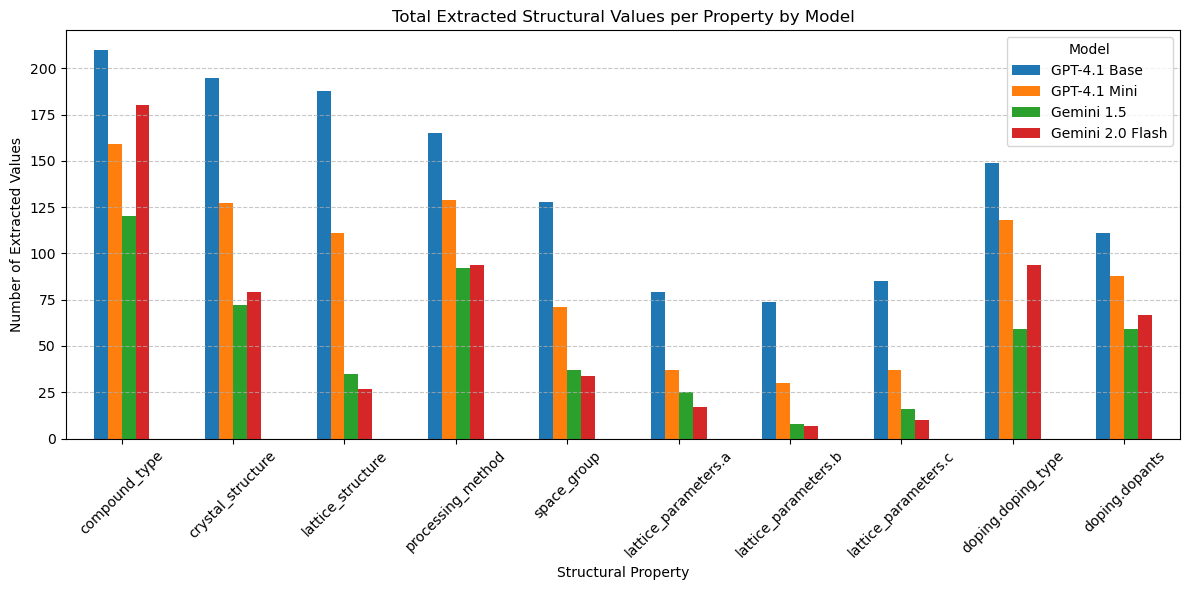

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === Load your CSV files ===
base_df = pd.read_csv("cleaned_gpt_4.1_thermo_structural.csv")
flash_df = pd.read_csv("cleaned_gemini_2.0_flash_thermo_structural.csv")
gem15_df = pd.read_csv("cleaned_gemini_1.5_pro_thermo_structural.csv")
mini_df = pd.read_csv("cleaned_gpt_4.1_mini_thermo_structural.csv")

# === Structural fields to check ===
structural_fields = [
    "compound_type", "crystal_structure", "lattice_structure", "processing_method", "space_group",
    "lattice_parameters.a", "lattice_parameters.b", "lattice_parameters.c",
    "doping.doping_type", "doping.dopants"
]

# === Count non-empty values per DOI ===
def compute_field_coverage(df, fields):
    summary = defaultdict(lambda: {f: 0 for f in fields})
    for _, row in df.iterrows():
        doi = row["doi"]
        for f in fields:
            val = row.get(f)
            if pd.notna(val) and str(val).strip() not in ["", "[]", "{}", "None"]:
                summary[doi][f] += 1
    return pd.DataFrame.from_dict(summary, orient="index")

# === Compute per-model coverage ===
base_cov = compute_field_coverage(base_df, structural_fields)
flash_cov = compute_field_coverage(flash_df, structural_fields)
gem15_cov = compute_field_coverage(gem15_df, structural_fields)
mini_cov = compute_field_coverage(mini_df, structural_fields)

# === Label and combine ===
base_cov["model"] = "GPT-4.1 Base"
flash_cov["model"] = "Gemini 2.0 Flash"
gem15_cov["model"] = "Gemini 1.5"
mini_cov["model"] = "GPT-4.1 Mini"

combined = pd.concat([base_cov, flash_cov, gem15_cov, mini_cov])
combined.reset_index(inplace=True)
combined.rename(columns={"index": "doi"}, inplace=True)

# === Aggregate and Plot ===
agg = combined.groupby("model")[structural_fields].sum().T  # Transpose so fields are rows
agg.plot(kind="bar", figsize=(12, 6), rot=45)

plt.title("Total Extracted Structural Values per Property by Model")
plt.ylabel("Number of Extracted Values")
plt.xlabel("Structural Property")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="Model")
plt.show()


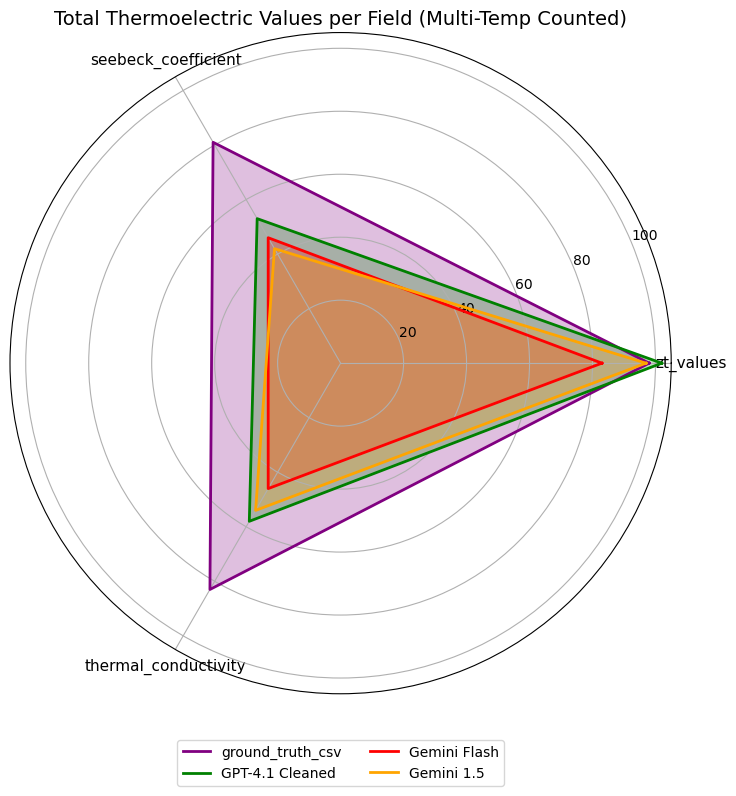

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# === Load your CSV files ===
gt_df=pd.read_csv("merged_thermo_structural.csv")
base_df = pd.read_csv("cleaned_gpt_4.1.csv")
flash_df = pd.read_csv("cleaned_gemini_2.0.csv")
gem15_df = pd.read_csv("cleaned_gemini_1.5_pro.csv")
mini_df = pd.read_csv("cleaned_gpt_4.1_mini.csv")

# === Thermoelectric fields to analyze ===
thermo_fields = ["zt_values","seebeck_coefficient",  "thermal_conductivity"]

# === Improved function: count each value inside list-like fields (e.g., multi-temp ZT) ===
def count_json_array_values(df, fields):
    result = {}
    for field in fields:
        count = 0
        for val in df[field]:
            if pd.isna(val) or str(val).strip() in ["", "[]", "{}", "None"]:
                continue
            try:
                parsed = ast.literal_eval(val) if isinstance(val, str) else val
                if isinstance(parsed, list):
                    count += len(parsed)
                else:
                    count += 1  # single value
            except:
                count += 1  # fallback if parsing fails
        result[field] = count
    return result

# === Apply counting to each model ===
totals = {
    "ground_truth_csv": count_json_array_values(gt_df, thermo_fields),
    "GPT-4.1 Cleaned": count_json_array_values(base_df, thermo_fields),
    "Gemini Flash": count_json_array_values(flash_df, thermo_fields),
    "Gemini 1.5": count_json_array_values(gem15_df, thermo_fields),
    "GPT-4.1 Mini": count_json_array_values(mini_df, thermo_fields),
}

df_totals = pd.DataFrame(totals)

# === Radar chart plotting ===
labels = df_totals.index.tolist()
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['purple', 'green', 'red', 'orange']
for model, color in zip(df_totals.columns, colors):
    values = df_totals[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_title("Total Thermoelectric Values per Field (Multi-Temp Counted)", size=14)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.grid(True)

plt.tight_layout()
plt.show()


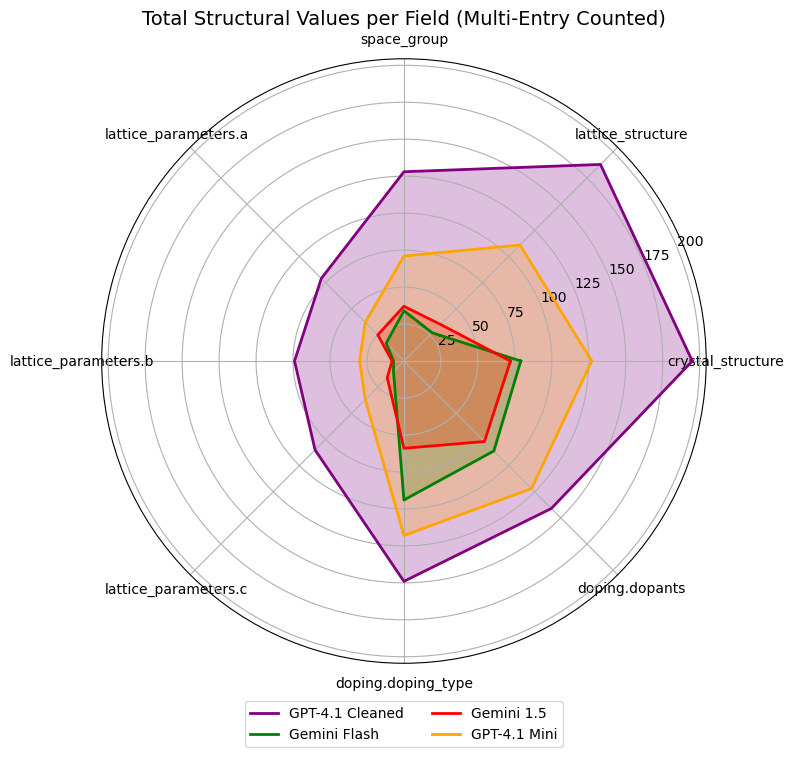

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# === Load your CSV files ===
base_df = pd.read_csv("cleaned_gpt_4.1_thermo_structural.csv")
flash_df = pd.read_csv("cleaned_gemini_2.0_flash_thermo_structural.csv")
gem15_df = pd.read_csv("cleaned_gemini_1.5_pro_thermo_structural.csv")
mini_df = pd.read_csv("cleaned_gpt_4.1_mini_thermo_structural.csv")

# === Structural fields to analyze ===
struct_fields = [
    "crystal_structure", "lattice_structure", "space_group",
    "lattice_parameters.a", "lattice_parameters.b", "lattice_parameters.c",
    "doping.doping_type", "doping.dopants"
]

# === Improved function: count each value inside list-like or complex fields ===
def count_json_array_values(df, fields):
    result = {}
    for field in fields:
        count = 0
        for val in df[field]:
            if pd.isna(val) or str(val).strip() in ["", "[]", "{}", "None"]:
                continue
            try:
                parsed = ast.literal_eval(val) if isinstance(val, str) else val
                if isinstance(parsed, list):
                    count += len(parsed)
                elif isinstance(parsed, dict):
                    count += len(parsed)
                else:
                    count += 1
            except:
                count += 1
        result[field] = count
    return result

# === Apply to each model ===
totals = {
    "GPT-4.1 Cleaned": count_json_array_values(base_df, struct_fields),
    "Gemini Flash": count_json_array_values(flash_df, struct_fields),
    "Gemini 1.5": count_json_array_values(gem15_df, struct_fields),
    "GPT-4.1 Mini": count_json_array_values(mini_df, struct_fields),
}

df_struct_totals = pd.DataFrame(totals)

# === Radar chart plotting ===
labels = df_struct_totals.index.tolist()
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['purple', 'green', 'red', 'orange']
for model, color in zip(df_struct_totals.columns, colors):
    values = df_struct_totals[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Total Structural Values per Field (Multi-Entry Counted)", size=14)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.grid(True)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import ast
from collections import defaultdict

# === CONFIG ===
ground_truth_csv = "merged_thermo_structural.csv"  # Change path
model_csvs = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_1.5_pro_filtered": "gemini_1.5_pro_thermo_structural_filtered.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}

tolerance_val = 0.001  # ±0.1% relative
tolerance_temp = 1.0   # ±1 K

# Field mapping: field -> (value keys, temperature keys)
properties_with_temp_keys = {
    "zt_values": (["value", "ZT_value"], ["ZT_temperature", "temperature", "T", "temp_K", "temp"]),
    "seebeck_coefficient": (["S_value", "value"], ["S_temperature", "temperature", "T", "temp_K", "temp"]),
    "thermal_conductivity": (["κ_value", "kappa_value", "value"], ["kappa_temperature", "thermal_conductivity_temperature", "temperature", "T", "temp_K", "temp"]),
}

# === HELPERS ===
def extract_dicts(text):
    """Parse JSON-like text to list of dicts."""
    try:
        parsed = ast.literal_eval(str(text))
        if not isinstance(parsed, list):
            parsed = [parsed]
        return [d for d in parsed if isinstance(d, dict)]
    except:
        return []

# === BUILD GT LOOKUP: doi -> field -> [(value, temp), ...] ===
df_gt = pd.read_csv(ground_truth_csv)
gt_lookup = defaultdict(lambda: defaultdict(list))

for _, row in df_gt.iterrows():
    doi = row.get("doi")
    for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
        dicts = extract_dicts(row.get(field, ""))
        for d in dicts:
            val, temp = None, None
            for k in val_keys:
                if k in d and d[k] not in [None, "", "None"]:
                    try:
                        val = float(d[k])
                    except:
                        pass
                    break
            for tk in temp_keys:
                if tk in d and d[tk] not in [None, "", "None"]:
                    try:
                        temp = float(d[tk])
                    except:
                        pass
                    break
            if val is not None:
                gt_lookup[doi][field].append((val, temp))

# === CALCULATE PRECISION & RECALL ===
metrics_summary = []

for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
    for model_name, path in model_csvs.items():
        df_model = pd.read_csv(path)
        pred_lookup = defaultdict(list)

        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        # Compare GT and Predictions
        tp, fp, fn = 0, 0, 0
        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]
            matched_gt = set()

            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    fp += 1

            fn += len(gt_vals) - len(matched_gt)

        precision = tp / (tp + fp) if tp + fp else 0
        recall = tp / (tp + fn) if tp + fn else 0

        metrics_summary.append({
            "Property": field,
            "Model": model_name,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "Precision": round(precision, 3),
            "Recall": round(recall, 3)
        })

# === SAVE OR PRINT RESULTS ===
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)
metrics_df.to_csv("precision_recall_results.csv", index=False)
print("\n✅ Saved precision_recall_results.csv")


                Property                    Model  TP  FP  FN  Precision  \
0              zt_values           gemini_1.5_pro  73   6  18      0.924   
1              zt_values  gemini_1.5_pro_filtered  77  10  14      0.885   
2              zt_values             gpt_4.1_mini  77  10  14      0.885   
3              zt_values                  gpt_4.1  80   8  11      0.909   
4    seebeck_coefficient           gemini_1.5_pro  37   3  19      0.925   
5    seebeck_coefficient  gemini_1.5_pro_filtered  49   4   7      0.925   
6    seebeck_coefficient             gpt_4.1_mini  49   4   7      0.925   
7    seebeck_coefficient                  gpt_4.1  49   2   7      0.961   
8   thermal_conductivity           gemini_1.5_pro  46   5   7      0.902   
9   thermal_conductivity  gemini_1.5_pro_filtered  51   7   2      0.879   
10  thermal_conductivity             gpt_4.1_mini  51   7   2      0.879   
11  thermal_conductivity                  gpt_4.1  51   6   2      0.895   

    Recall 

In [5]:
overall = {}
for model, props in results.items():
    TP = sum(m['TP'] for m in props.values())
    FP = sum(m['FP'] for m in props.values())
    FN = sum(m['FN'] for m in props.values())
    precision = TP / (TP + FP) if TP + FP else 0
    recall = TP / (TP + FN) if TP + FN else 0
    overall[model] = {"precision": round(precision, 3), "recall": round(recall, 3)}

pd.DataFrame(overall).T

,precision,recall
gemini_1.5_pro,0.486,0.810
gemini_1.5_pro_filtered,0.661,0.905
gpt_4.1_mini,0.511,0.905
gpt_4.1,0.514,0.925


In [ ]:
import pandas as pd
import ast
from collections import defaultdict

# === CONFIG ===
ground_truth_csv = "merged_thermo_structural.csv"  # Change path
model_csvs = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_2.0_flash": "gemini_2.0_flash_thermo_structural.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}


tolerance_val = 0.001  # ±0.1% relative
tolerance_temp = 1.0   # ±1 K

# Field mapping: field -> (value keys, temperature keys)
properties_with_temp_keys = {
    "zt_values": (["value", "ZT_value"], ["ZT_temperature", "temperature", "T", "temp_K", "temp"]),
    "seebeck_coefficient": (["S_value", "value"], ["S_temperature", "temperature", "T", "temp_K", "temp"]),
    "thermal_conductivity": (["κ_value", "kappa_value", "value"], ["κ_temperature", "kappa_temperature", "thermal_conductivity_temperature", "temperature", "T", "temp_K", "temp"]),
}

# === HELPERS ===
def extract_dicts(text):
    """Parse JSON-like text to list of dicts."""
    try:
        parsed = ast.literal_eval(str(text))
        if not isinstance(parsed, list):
            parsed = [parsed]
        return [d for d in parsed if isinstance(d, dict)]
    except:
        return []

# === BUILD GT LOOKUP: doi -> field -> [(value, temp), ...] ===
df_gt = pd.read_csv(ground_truth_csv)
gt_lookup = defaultdict(lambda: defaultdict(list))

for _, row in df_gt.iterrows():
    doi = row.get("doi")
    for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
        dicts = extract_dicts(row.get(field, ""))
        for d in dicts:
            val, temp = None, None
            for k in val_keys:
                if k in d and d[k] not in [None, "", "None"]:
                    try:
                        val = float(d[k])
                    except:
                        pass
                    break
            for tk in temp_keys:
                if tk in d and d[tk] not in [None, "", "None"]:
                    try:
                        temp = float(d[tk])
                    except:
                        pass
                    break
            if val is not None:
                gt_lookup[doi][field].append((val, temp))

# === CALCULATE PRECISION/RECALL/F1 (per property) + OVERALL MICRO & MACRO ===
results_wide = defaultdict(dict)

# Totals for micro-averaging across all properties (sum TP/FP/FN)
overall_micro = {m: {"TP": 0, "FP": 0, "FN": 0} for m in model_csvs.keys()}
# Lists for macro-averaging (mean of per-property P/R/F1)
overall_macro = defaultdict(lambda: {"P_list": [], "R_list": [], "F1_list": []})

for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
    for model_name, path in model_csvs.items():
        df_model = pd.read_csv(path)
        pred_lookup = defaultdict(list)

        # Build predictions lookup: doi -> [(val,temp), ...]
        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        # Compare GT and Predictions for this property+model
        tp, fp, fn = 0, 0, 0
        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]
            matched_gt = set()

            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    fp += 1
            fn += len(gt_vals) - len(matched_gt)

        P = tp / (tp + fp) if (tp + fp) else 0.0
        R = tp / (tp + fn) if (tp + fn) else 0.0
        F1 = (2 * P * R / (P + R)) if (P + R) else 0.0

        results_wide[model_name][field] = f"P={round(P,3)}, R={round(R,3)}, F1={round(F1,3)}"

        # accumulate for micro
        overall_micro[model_name]["TP"] += tp
        overall_micro[model_name]["FP"] += fp
        overall_micro[model_name]["FN"] += fn

        # accumulate for macro
        overall_macro[model_name]["P_list"].append(P)
        overall_macro[model_name]["R_list"].append(R)
        overall_macro[model_name]["F1_list"].append(F1)

# Compute Overall (micro) & Overall (macro) and attach to table
for model_name in model_csvs.keys():
    # micro
    TP, FP, FN = overall_micro[model_name]["TP"], overall_micro[model_name]["FP"], overall_micro[model_name]["FN"]
    P_micro = TP / (TP + FP) if (TP + FP) else 0.0
    R_micro = TP / (TP + FN) if (TP + FN) else 0.0
    F1_micro = (2 * P_micro * R_micro / (P_micro + R_micro)) if (P_micro + R_micro) else 0.0

    # macro
    P_list = overall_macro[model_name]["P_list"] or [0.0]
    R_list = overall_macro[model_name]["R_list"] or [0.0]
    F1_list = overall_macro[model_name]["F1_list"] or [0.0]
    P_macro = sum(P_list) / len(P_list)
    R_macro = sum(R_list) / len(R_list)
    F1_macro = sum(F1_list) / len(F1_list)

    results_wide[model_name]["Overall_micro"] = f"P={round(P_micro,3)}, R={round(R_micro,3)}, F1={round(F1_micro,3)}"
    results_wide[model_name]["Overall_macro"] = f"P={round(P_macro,3)}, R={round(R_macro,3)}, F1={round(F1_macro,3)}"

# === CONVERT TO WIDE DATAFRAME ===
df_results_wide = pd.DataFrame(results_wide).T.reset_index()
df_results_wide.rename(columns={"index": "Model"}, inplace=True)

# Optional: rename property columns to short names
rename_map = {
    "zt_values": "ZT",
    "seebeck_coefficient": "S",
    "thermal_conductivity": "kappa",
}
df_results_wide.rename(columns=rename_map, inplace=True)

print(df_results_wide)




              Model                          ZT                           S  \
0    gemini_1.5_pro  P=0.924, R=0.802, F1=0.859  P=0.925, R=0.661, F1=0.771   
1  gemini_2.0_flash   P=0.897, R=0.67, F1=0.767   P=0.977, R=0.75, F1=0.848   
2      gpt_4.1_mini  P=0.885, R=0.846, F1=0.865  P=0.925, R=0.875, F1=0.899   
3           gpt_4.1  P=0.909, R=0.879, F1=0.894  P=0.961, R=0.875, F1=0.916   

                        kappa               Overall_micro  \
0  P=0.902, R=0.868, F1=0.885   P=0.918, R=0.78, F1=0.843   
1   P=0.837, R=0.679, F1=0.75  P=0.903, R=0.695, F1=0.785   
2  P=0.879, R=0.962, F1=0.919  P=0.894, R=0.885, F1=0.889   
3  P=0.895, R=0.962, F1=0.927    P=0.918, R=0.9, F1=0.909   

                Overall_macro  
0  P=0.917, R=0.777, F1=0.838  
1    P=0.904, R=0.7, F1=0.789  
2  P=0.896, R=0.894, F1=0.894  
3  P=0.922, R=0.905, F1=0.912  


In [2]:
import pandas as pd
import ast
from collections import defaultdict

# === CONFIG ===
ground_truth_csv = "merged_thermo_structural.csv"  # Change path
model_csvs = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_2.0_flash": "gemini_2.0_flash_thermo_structural.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}

tolerance_val = 0.001  # ±0.1% relative
tolerance_temp = 1.0   # ±1 K

# Field mapping: field -> (value keys, temperature keys)
properties_with_temp_keys = {
    "zt_values": (["value", "ZT_value"], ["ZT_temperature", "temperature", "T", "temp_K", "temp"]),
    "seebeck_coefficient": (["S_value", "value"], ["S_temperature", "temperature", "T", "temp_K", "temp"]),
    "thermal_conductivity": (["κ_value", "kappa_value", "value"], ["kappa_temperature", "thermal_conductivity_temperature", "temperature", "T", "temp_K", "temp"]),
}

# === HELPERS ===
def extract_dicts(text):
    """Parse JSON-like text to list of dicts."""
    try:
        parsed = ast.literal_eval(str(text))
        if not isinstance(parsed, list):
            parsed = [parsed]
        return [d for d in parsed if isinstance(d, dict)]
    except:
        return []

# === BUILD GT LOOKUP: doi -> field -> [(value, temp), ...] ===
df_gt = pd.read_csv(ground_truth_csv)
gt_lookup = defaultdict(lambda: defaultdict(list))

for _, row in df_gt.iterrows():
    doi = row.get("doi")
    for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
        dicts = extract_dicts(row.get(field, ""))
        for d in dicts:
            val, temp = None, None
            for k in val_keys:
                if k in d and d[k] not in [None, "", "None"]:
                    try:
                        val = float(d[k])
                    except:
                        pass
                    break
            for tk in temp_keys:
                if tk in d and d[tk] not in [None, "", "None"]:
                    try:
                        temp = float(d[tk])
                    except:
                        pass
                    break
            if val is not None:
                gt_lookup[doi][field].append((val, temp))

# === CALCULATE PRECISION/RECALL/F1 + COUNTS ===
results_wide = defaultdict(dict)

# Totals for micro-averaging across all properties
overall_micro = {m: {"TP": 0, "FP": 0, "FN": 0} for m in model_csvs.keys()}
# Lists for macro-averaging
overall_macro = defaultdict(lambda: {"P_list": [], "R_list": [], "F1_list": []})

for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
    for model_name, path in model_csvs.items():
        df_model = pd.read_csv(path)
        pred_lookup = defaultdict(list)

        # Build predictions lookup: doi -> [(val,temp), ...]
        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        # Compare GT and Predictions for this property+model
        tp, fp, fn = 0, 0, 0
        gt_total, pred_total = 0, 0

        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]

            gt_total += len(gt_vals)
            pred_total += len(pred_vals)

            matched_gt = set()
            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    fp += 1
            fn += len(gt_vals) - len(matched_gt)

        P = tp / (tp + fp) if (tp + fp) else 0.0
        R = tp / (tp + fn) if (tp + fn) else 0.0
        F1 = (2 * P * R / (P + R)) if (P + R) else 0.0

        # Save metrics and counts
        results_wide[model_name][field] = f"P={round(P,3)}, R={round(R,3)}, F1={round(F1,3)}"
        results_wide[model_name][f"{field}_GT_count"] = gt_total
        results_wide[model_name][f"{field}_Pred_count"] = pred_total
        results_wide[model_name][f"{field}_TP_count"] = tp

        # accumulate for micro
        overall_micro[model_name]["TP"] += tp
        overall_micro[model_name]["FP"] += fp
        overall_micro[model_name]["FN"] += fn

        # accumulate for macro
        overall_macro[model_name]["P_list"].append(P)
        overall_macro[model_name]["R_list"].append(R)
        overall_macro[model_name]["F1_list"].append(F1)

# Compute Overall (micro) & Overall (macro)
for model_name in model_csvs.keys():
    TP, FP, FN = overall_micro[model_name]["TP"], overall_micro[model_name]["FP"], overall_micro[model_name]["FN"]
    P_micro = TP / (TP + FP) if (TP + FP) else 0.0
    R_micro = TP / (TP + FN) if (TP + FN) else 0.0
    F1_micro = (2 * P_micro * R_micro / (P_micro + R_micro)) if (P_micro + R_micro) else 0.0

    P_list = overall_macro[model_name]["P_list"] or [0.0]
    R_list = overall_macro[model_name]["R_list"] or [0.0]
    F1_list = overall_macro[model_name]["F1_list"] or [0.0]
    P_macro = sum(P_list) / len(P_list)
    R_macro = sum(R_list) / len(R_list)
    F1_macro = sum(F1_list) / len(F1_list)

    results_wide[model_name]["Overall_micro"] = f"P={round(P_micro,3)}, R={round(R_micro,3)}, F1={round(F1_micro,3)}"
    results_wide[model_name]["Overall_macro"] = f"P={round(P_macro,3)}, R={round(R_macro,3)}, F1={round(F1_macro,3)}"

# === CONVERT TO WIDE DATAFRAME ===
df_results_wide = pd.DataFrame(results_wide).T.reset_index()
df_results_wide.rename(columns={"index": "Model"}, inplace=True)

# Optional: rename property columns to short names
rename_map = {
    "zt_values": "ZT",
    "seebeck_coefficient": "S",
    "thermal_conductivity": "kappa",
}
df_results_wide.rename(columns=rename_map, inplace=True)

print(df_results_wide)


              Model                          ZT zt_values_GT_count  \
0    gemini_1.5_pro  P=0.924, R=0.802, F1=0.859                 91   
1  gemini_2.0_flash   P=0.897, R=0.67, F1=0.767                 91   
2      gpt_4.1_mini  P=0.885, R=0.846, F1=0.865                 91   
3           gpt_4.1  P=0.909, R=0.879, F1=0.894                 91   

  zt_values_Pred_count zt_values_TP_count                           S  \
0                   79                 73  P=0.925, R=0.661, F1=0.771   
1                   68                 61   P=0.977, R=0.75, F1=0.848   
2                   87                 77  P=0.925, R=0.875, F1=0.899   
3                   88                 80  P=0.961, R=0.875, F1=0.916   

  seebeck_coefficient_GT_count seebeck_coefficient_Pred_count  \
0                           56                             40   
1                           56                             43   
2                           56                             53   
3                      

In [3]:
# === BUILD COUNTS TABLE (GT vs Pred vs TP) ===

count_rows = []

for model_name in model_csvs.keys():
    row = {"Model": model_name}
    for field in properties_with_temp_keys.keys():
        row[f"{field}_GT"] = results_wide[model_name].get(f"{field}_GT_count", 0)
        row[f"{field}_Pred"] = results_wide[model_name].get(f"{field}_Pred_count", 0)
        row[f"{field}_TP"] = results_wide[model_name].get(f"{field}_TP_count", 0)
    count_rows.append(row)

df_counts = pd.DataFrame(count_rows)

# Optional: rename property columns to shorter names
rename_map_counts = {
    "zt_values_GT": "ZT_GT",
    "zt_values_Pred": "ZT_Pred",
    "zt_values_TP": "ZT_TP",
    "seebeck_coefficient_GT": "S_GT",
    "seebeck_coefficient_Pred": "S_Pred",
    "seebeck_coefficient_TP": "S_TP",
    "thermal_conductivity_GT": "kappa_GT",
    "thermal_conductivity_Pred": "kappa_Pred",
    "thermal_conductivity_TP": "kappa_TP",
}
df_counts.rename(columns=rename_map_counts, inplace=True)

print("\n=== Counts Table (GT vs Pred vs TP) ===")
print(df_counts)



=== Counts Table (GT vs Pred vs TP) ===
              Model  ZT_GT  ZT_Pred  ZT_TP  S_GT  S_Pred  S_TP  kappa_GT  \
0    gemini_1.5_pro     91       79     73    56      40    37        53   
1  gemini_2.0_flash     91       68     61    56      43    42        53   
2      gpt_4.1_mini     91       87     77    56      53    49        53   
3           gpt_4.1     91       88     80    56      51    49        53   

   kappa_Pred  kappa_TP  
0          51        46  
1          43        36  
2          58        51  
3          57        51  


In [4]:
# === BUILD CONFUSION MATRIX PER MODEL PER PROPERTY ===
confusion_rows = []

for field in properties_with_temp_keys.keys():
    for model_name in model_csvs.keys():
        # Recompute TP/FP/FN for this model and property
        df_model = pd.read_csv(model_csvs[model_name])
        pred_lookup = defaultdict(list)

        val_keys, temp_keys = properties_with_temp_keys[field]
        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        tp, fp, fn = 0, 0, 0
        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]
            matched_gt = set()
            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    fp += 1
            fn += len(gt_vals) - len(matched_gt)

        confusion_rows.append({
            "Model": model_name,
            "Property": field,
            "TP": tp,
            "FP": fp,
            "FN": fn
        })

df_confusion = pd.DataFrame(confusion_rows)
print("\n=== Confusion Matrices (per model × property) ===")
print(df_confusion)



=== Confusion Matrices (per model × property) ===
               Model              Property  TP  FP  FN
0     gemini_1.5_pro             zt_values  73   6  18
1   gemini_2.0_flash             zt_values  61   7  30
2       gpt_4.1_mini             zt_values  77  10  14
3            gpt_4.1             zt_values  80   8  11
4     gemini_1.5_pro   seebeck_coefficient  37   3  19
5   gemini_2.0_flash   seebeck_coefficient  42   1  14
6       gpt_4.1_mini   seebeck_coefficient  49   4   7
7            gpt_4.1   seebeck_coefficient  49   2   7
8     gemini_1.5_pro  thermal_conductivity  46   5   7
9   gemini_2.0_flash  thermal_conductivity  36   7  17
10      gpt_4.1_mini  thermal_conductivity  51   7   2
11           gpt_4.1  thermal_conductivity  51   6   2


/tmp/ipykernel_473/2932293804.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  counts = [int(row["TP"]), int(row["FP"]), int(row["FN"])]


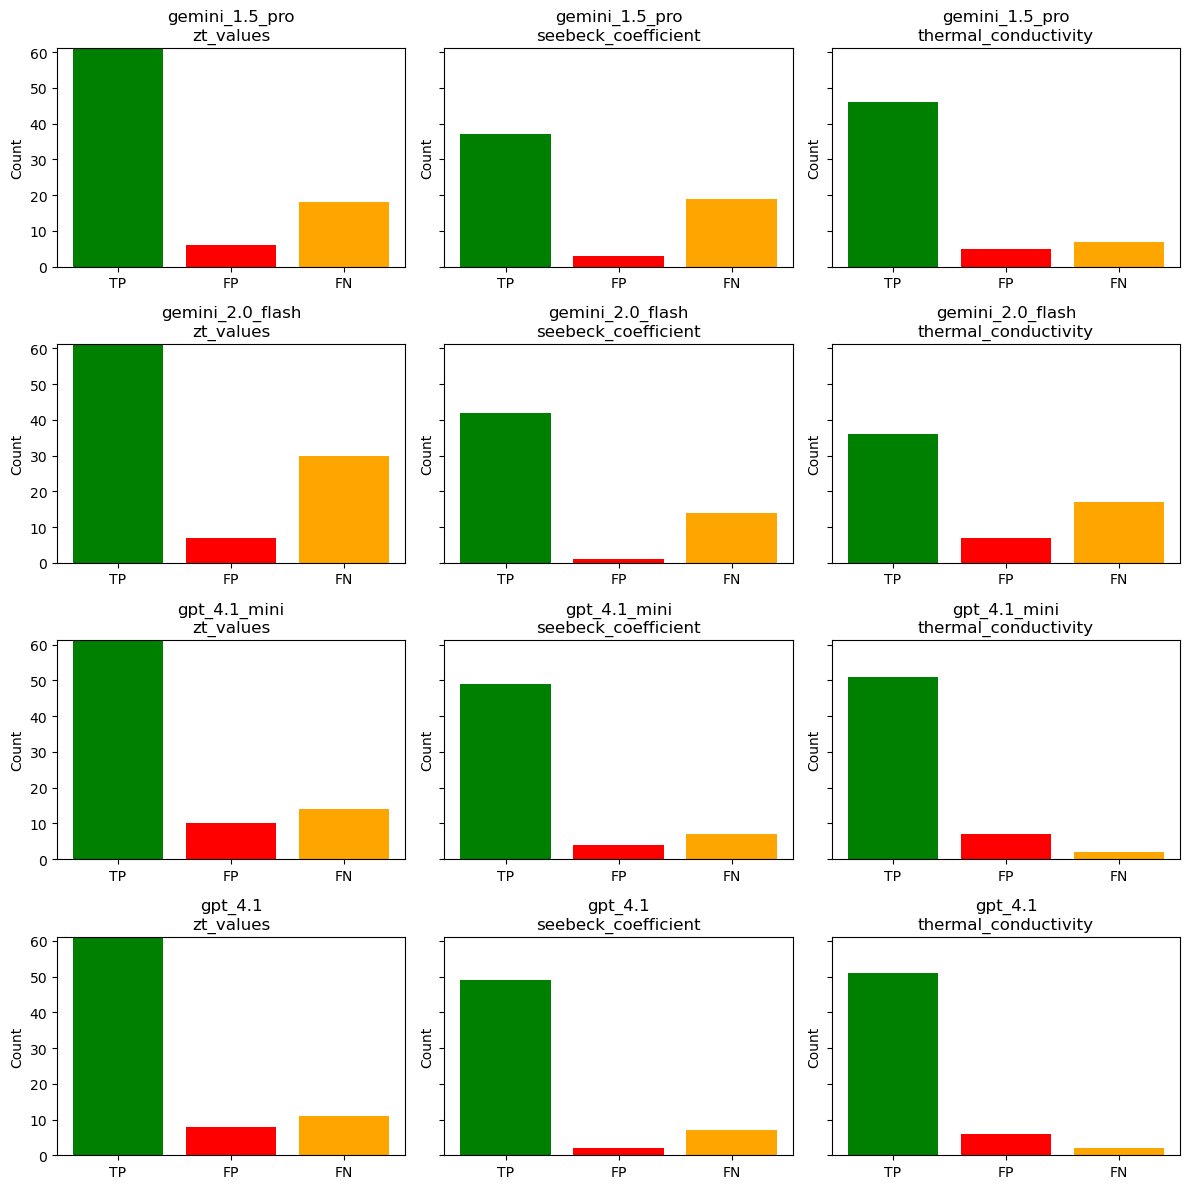

In [5]:
import matplotlib.pyplot as plt

# === PLOT CONFUSION COUNTS IN SUBPLOTS ===

models = df_confusion["Model"].unique()
properties = df_confusion["Property"].unique()

fig, axes = plt.subplots(len(models), len(properties), figsize=(4*len(properties), 3*len(models)), sharey=True)

if len(models) == 1 and len(properties) == 1:
    axes = [[axes]]
elif len(models) == 1:
    axes = [axes]
elif len(properties) == 1:
    axes = [[ax] for ax in axes]

for i, model in enumerate(models):
    for j, prop in enumerate(properties):
        ax = axes[i][j]
        row = df_confusion[(df_confusion["Model"] == model) & (df_confusion["Property"] == prop)]
        if not row.empty:
            counts = [int(row["TP"]), int(row["FP"]), int(row["FN"])]
            ax.bar(["TP", "FP", "FN"], counts, color=["green", "red", "orange"])
            ax.set_title(f"{model}\n{prop}")
            ax.set_ylabel("Count")
            ax.set_ylim(0, max(counts) * 1.2 if max(counts) > 0 else 1)

plt.tight_layout()
plt.show()


In [3]:
# === EAS/HR (property-scoped, temp-aware) ===
eas_rows = []

def rel_close(a, b, rtol=0.001):
    return abs(a - b) / max(abs(a), abs(b), 1e-6) <= rtol

for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
    for model_name, path in model_csvs.items():
        df_model = pd.read_csv(path)
        pred_lookup = defaultdict(list)

        # Build predictions lookup for THIS property
        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try: val = float(d[k])
                        except: pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try: temp = float(d[tk])
                        except: pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        total_preds = 0
        supported_weak = 0   # value-only
        supported_strict = 0 # value + temperature

        for doi, preds in pred_lookup.items():
            gt_vals = gt_lookup[doi][field]  # <-- ONLY this property now
            for p_val, p_temp in preds:
                total_preds += 1
                weak = any(rel_close(p_val, g_val, tolerance_val) for g_val, _ in gt_vals)
                if weak:
                    supported_weak += 1
                strict = any(
                    rel_close(p_val, g_val, tolerance_val) and
                    (p_temp is not None and g_temp is not None and abs(p_temp - g_temp) <= tolerance_temp)
                    for g_val, g_temp in gt_vals
                )
                if strict:
                    supported_strict += 1

        eas_weak  = supported_weak  / total_preds if total_preds else 0.0
        hr_weak   = 1 - eas_weak
        eas_strict = supported_strict / total_preds if total_preds else 0.0
        hr_strict  = 1 - eas_strict

        eas_rows.append({
            "Model": model_name,
            "Property": field,
            "EAS_weak": round(eas_weak, 3),
            "HR_weak": round(hr_weak, 3),
            "EAS_strict": round(eas_strict, 3),
            "HR_strict": round(hr_strict, 3),
            "Total_preds": total_preds
        })

df_eas = pd.DataFrame(eas_rows)

# Optional: aggregate to overall micro EAS per model (sum over properties)
agg = (df_eas.groupby("Model")
              .apply(lambda g: pd.Series({
                  "EAS_weak_overall": round((g["EAS_weak"] * g["Total_preds"]).sum() / max(g["Total_preds"].sum(), 1), 3),
                  "HR_weak_overall":  round(1 - (g["EAS_weak"] * g["Total_preds"]).sum() / max(g["Total_preds"].sum(), 1), 3),
                  "EAS_strict_overall": round((g["EAS_strict"] * g["Total_preds"]).sum() / max(g["Total_preds"].sum(), 1), 3),
                  "HR_strict_overall":  round(1 - (g["EAS_strict"] * g["Total_preds"]).sum() / max(g["Total_preds"].sum(), 1), 3),
                  "Total_preds": int(g["Total_preds"].sum())
              })).reset_index())

print(df_eas)
print(agg)


               Model              Property  EAS_weak  HR_weak  EAS_strict  \
0     gemini_1.5_pro             zt_values       1.0      0.0       0.797   
1   gemini_2.0_flash             zt_values       1.0      0.0       0.794   
2       gpt_4.1_mini             zt_values       1.0      0.0       0.885   
3            gpt_4.1             zt_values       1.0      0.0       0.875   
4     gemini_1.5_pro   seebeck_coefficient       1.0      0.0       0.000   
5   gemini_2.0_flash   seebeck_coefficient       1.0      0.0       0.000   
6       gpt_4.1_mini   seebeck_coefficient       1.0      0.0       0.000   
7            gpt_4.1   seebeck_coefficient       1.0      0.0       0.000   
8     gemini_1.5_pro  thermal_conductivity       1.0      0.0       0.000   
9   gemini_2.0_flash  thermal_conductivity       1.0      0.0       0.000   
10      gpt_4.1_mini  thermal_conductivity       1.0      0.0       0.000   
11           gpt_4.1  thermal_conductivity       1.0      0.0       0.000   

C:\Users\hp\AppData\Local\Temp\ipykernel_28352\443639026.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [ ]:
# === SAVE ===
df_results_wide.to_csv("precision_recall_f1_micro_macro.csv", index=False)
print("\n✅ Saved precision_recall_f1_micro_macro.csv")

In [6]:
# After results_wide calculation, also compute overall accuracy
overall_metrics = []

for model_name in model_csvs.keys():
    total_tp, total_fp, total_fn = 0, 0, 0
    for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
        # Parse the P, R string back from results_wide is not needed
        # Instead, re-run calculation for totals
        df_model = pd.read_csv(model_csvs[model_name])
        pred_lookup = defaultdict(list)

        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        # Compare GT and Predictions
        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]
            matched_gt = set()

            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        total_tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    total_fp += 1

            total_fn += len(gt_vals) - len(matched_gt)

    accuracy = total_tp / (total_tp + total_fp + total_fn) if (total_tp + total_fp + total_fn) else 0
    overall_metrics.append({"Model": model_name, "Overall_Accuracy": round(accuracy, 3)})

df_overall = pd.DataFrame(overall_metrics)
df_overall


,Model,Overall_Accuracy
0,gemini_1.5_pro,0.729
1,gemini_1.5_pro_filtered,0.801
2,gpt_4.1_mini,0.801
3,gpt_4.1,0.833


In [3]:
import pandas as pd
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util

# === CONFIG ===
ground_truth_csv = "merged_thermo_structural.csv"
model_csvs = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_2.0_flash": "gemini_2.0_flash_thermo_structural.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}

# === Load data ===
df_gt = pd.read_csv(ground_truth_csv)
dfs_models = {name: pd.read_csv(path) for name, path in model_csvs.items()}

# === Synonym mapping for crystal_structure ===
crystal_map = {
    "cubic": ["cubic", "fcc", "bcc"],
    "hexagonal": ["hexagonal", "hcp"],
    "tetragonal": ["tetragonal"],
    "orthorhombic": ["orthorhombic"],
}

def normalize_crystal(val):
    if pd.isna(val) or val is None:
        return None
    v = str(val).strip().lower()
    for canon, variants in crystal_map.items():
        if v in variants:
            return canon
    return v

# === Embedding model ===
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_match(pred, truth, threshold=0.8):
    """Return True if pred ≈ truth (semantic similarity)"""
    if pred == truth:  # already normalized match
        return True
    if not pred or not truth:
        return False
    emb_pred = embedder.encode(pred, convert_to_tensor=True)
    emb_truth = embedder.encode(truth, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(emb_pred, emb_truth).item()
    return sim >= threshold

# === Build GT lookup for crystal_structure ===
gt_lookup_crystal = {}
for _, row in df_gt.iterrows():
    doi = row.get("doi")
    gt_lookup_crystal[doi] = normalize_crystal(row.get("crystal_structure"))

# === Benchmark crystal_structure ===
results_crystal_semantic = {}
for model_name, df_model in dfs_models.items():
    tp, fp, fn = 0, 0, 0
    for _, row in df_model.iterrows():
        doi = row.get("doi")
        pred_val = normalize_crystal(row.get("crystal_structure"))
        true_val = gt_lookup_crystal.get(doi)

        if true_val is None and pred_val is None:
            continue
        elif semantic_match(pred_val, true_val):
            tp += 1
        elif pred_val is not None and true_val is not None:
            fp += 1
            fn += 1
        elif pred_val is not None and true_val is None:
            fp += 1
        elif pred_val is None and true_val is not None:
            fn += 1

    P = tp / (tp + fp) if (tp + fp) else 0.0
    R = tp / (tp + fn) if (tp + fn) else 0.0
    F1 = (2 * P * R / (P + R)) if (P + R) else 0.0
    results_crystal_semantic[model_name] = (round(P,3), round(R,3), round(F1,3))

# === Show results ===
print("\nBenchmark Results for crystal_structure (semantic similarity ≥ 0.8):")
for model, (P, R, F1) in results_crystal_semantic.items():
    print(f"{model:15s}  Precision={P}, Recall={R}, F1={F1}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Benchmark Results for crystal_structure (semantic similarity ≥ 0.8):
gemini_1.5_pro   Precision=0.313, Recall=0.134, F1=0.188
gemini_2.0_flash  Precision=0.276, Recall=0.093, F1=0.139
gpt_4.1_mini     Precision=0.456, Recall=0.33, F1=0.383
gpt_4.1          Precision=0.267, Recall=0.238, F1=0.252


In [29]:

"""
Benchmark structural fields with hierarchical ontology + relaxed doping matching.

Evaluates:
- lattice_structure
- compound_type
- doping.doping_type (relaxed: "p" ≈ "p type", "n" ≈ "n type")

Outputs: prints per-field and overall results
"""

import re, math, random
from typing import Optional, Dict, Set, List
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

from sentence_transformers import SentenceTransformer

try:
    from rapidfuzz import fuzz
    def str_sim(a,b): return fuzz.token_sort_ratio(a,b)/100.0
except:
    import difflib
    def str_sim(a,b): return difflib.SequenceMatcher(a=a,b=b).ratio()

# ---------------- Config ----------------
GROUND_TRUTH_CSV = "merged_thermo_structural.csv"
MODEL_CSVS = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_2.0_flash": "gemini_2.0_flash_thermo_structural.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}

ID_COL = "doi"
FIELDS = ["lattice_structure", "compound_type", "doping.doping_type"]
EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ---------------- Ontologies ----------------
LATTICE_MAP = {
    "fcc": {"fcc","face centered cubic","rocksalt"},
    "bcc": {"bcc","body centered cubic"},
    "hcp": {"hcp","hexagonal close packed"},
    "wurtzite": {"wurtzite"},
    "zincblende": {"zincblende","sphalerite"},
    "perovskite": {"perovskite","abx3"},
    "fluorite": {"fluorite"},
    "rutile": {"rutile"},
}

COMPOUND_MAP = {
    "oxide": {"oxide","oxides","metal oxide","transition metal oxide"},
    "chalcogenide": {"chalcogenide","sulfide","selenide","telluride"},
    "pnictide": {"pnictide","phosphide","arsenide","antimonide"},
    "intermetallic": {"intermetallic"},
    "halide": {"halide","chloride","bromide","iodide","fluoride"},
    "carbide/nitride/boride": {"carbide","nitride","boride"},
    "perovskite": {"perovskite","oxide perovskite"},
}

# === Base Ontology ===
DOPING_MAP = {
    "n type": {
        "n type","n-type","n doped","n-type doped",
        "electron doped","donor doped","n-type semiconductor",
        "n-type matrix","cl-doped","f-doped","nb-doped",
        "halogen doped","oxygen vacancy","anion vacancy",
    },
    "p type": {
        "p type","p-type","p doped","p-type doped",
        "hole doped","acceptor doped","p-type semiconductor",
        "alkali doped","na-doped","k-doped","li-doped",
        "sr-doped","ca-doped","ba-doped",
    },
    "intrinsic": {
        "intrinsic","undoped","isovalent substitution",
    },
    "compensated": {
        "compensated","ambipolar","bipolar",
        "n-type matrix with p-type nanoinclusions",
        "co-doping"
    },
    "doped-unknown": {
        "doped","doping","substitutional",
        "aliovalent substitution","magnetic doping","non-stoichiometry"
    }
}

# === Chemistry-informed dopant dictionary ===
DOPANT_DICT = {
    # Alkali metals (acceptors → p-type)
    "li": "p type", "na": "p type", "k": "p type", "rb": "p type", "cs": "p type",

    # Alkaline earths (acceptors → p-type)
    "mg": "p type", "ca": "p type", "sr": "p type", "ba": "p type",

    # Group 13 acceptors
    "al": "p type", "ga": "p type", "in": "p type", "tl": "p type",

    # Group 15 donors
    "sb": "n type", "bi": "n type",

    # Transition metal donors
    "nb": "n type", "ta": "n type", "w": "n type",
    "mo": "n type", "ti": "n type", "zr": "n type", "hf": "n type",

    # Halogen donors
    "f": "n type", "cl": "n type", "br": "n type", "i": "n type",

    # Light element dopants
    "h": "n type", "c": "p type", "n": "p type",
    # Vacancies
    "oxygen vacancy": "n type",
    "anion vacancy": "n type",
    "cation vacancy": "n type",
}

# === Helper function for integration ===
def classify_dopant_string(text: str) -> str:
    if not text:
        return "doped-unknown"
    s = str(text).lower()

    # First check ontology keywords
    for cls, variants in DOPING_MAP.items():
        if s in variants:
            return cls

    # Then check dopant dictionary rules
    found_types = set()
    for dopant, dtype in DOPANT_DICT.items():
        if dopant in s:
            found_types.add(dtype)

    if len(found_types) == 1:
        return list(found_types)[0]
    elif len(found_types) > 1:
        return "compensated"

    return "doped-unknown"


ONTOLOGY = {
    "lattice_structure": LATTICE_MAP,
    "compound_type": COMPOUND_MAP,
    "doping.doping_type": DOPING_MAP,
}

UNKNOWN_TOKENS = {"unknown","na","n/a","none","null","-","—"}

# ---------------- Helpers ----------------
def norm_text(x: Optional[str]) -> Optional[str]:
    if x is None or (isinstance(x,float) and math.isnan(x)): return None
    s = str(x).strip().lower()
    if not s or s in UNKNOWN_TOKENS: return None
    s = re.sub(r"\\s+"," ",s)
    return s

def map_to_class(val: Optional[str], field: str, ontology: Dict[str,Set[str]]) -> Optional[str]:
    v = norm_text(val)
    if v is None: return None
    for cls,variants in ontology.items():
        if v in variants: return cls
    return None

# ---------------- Classifier ----------------
class FieldClassifier:
    def __init__(self, field:str, ontology:Dict[str,Set[str]], embedder):
        self.field = field
        self.ontology = ontology
        self.embedder = embedder
        self.clf = None
        self.le = None

    def _embed(self, texts: List[str]) -> np.ndarray:
        return self.embedder.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

    def train(self, df_gt: pd.DataFrame):
        X_texts, y_labels = [], []
        for _,r in df_gt.iterrows():
            v = norm_text(r.get(self.field))
            if v is None: continue
            cls = map_to_class(v,self.field,self.ontology) or "other"
            X_texts.append(v); y_labels.append(cls)
        if not X_texts: return
        X = self._embed(X_texts)
        self.le = LabelEncoder()
        y = self.le.fit_transform(y_labels)
        self.clf = LogisticRegression(max_iter=300,class_weight="balanced")
        self.clf.fit(X,y)

    def predict_class(self, text: Optional[str]) -> Optional[str]:
        v = norm_text(text)
        if v is None: return None
        cls = map_to_class(v,self.field,self.ontology)
        if cls: return cls
        if self.clf is None: return None
        emb = self._embed([v])
        idx = self.clf.predict(emb)[0]
        return self.le.inverse_transform([idx])[0]

# ---------------- Evaluation ----------------
def eval_field(df_gt, df_model, field, clf_obj: FieldClassifier):
    rows=[]
    gt_lookup={str(r[ID_COL]):r.get(field) for _,r in df_gt.iterrows()}
    for _,r in df_model.iterrows():
        doi=str(r[ID_COL])
        gt_val=gt_lookup.get(doi)
        pred_val=r.get(field)

        # Special handling for doping
        if field == "doping.doping_type":
            gt_class = classify_dopant_string(gt_val)
            pred_class = classify_dopant_string(pred_val)
            if gt_class and pred_class:
                if gt_class.startswith("p") and pred_class.startswith("p"):
                    pred_class=gt_class
                elif gt_class.startswith("n") and pred_class.startswith("n"):
                    pred_class=gt_class
                elif gt_class in ["n type","p type"] and pred_class=="doped-unknown":
                    pred_class=gt_class
                elif "n" in pred_class and "p" in pred_class:
                    pred_class="compensated"
        else:
            gt_class = clf_obj.predict_class(gt_val)
            pred_class = clf_obj.predict_class(pred_val) or "other"

        rows.append((doi,gt_class,pred_class))

    df_eval=pd.DataFrame(rows,columns=["doi","gt_class","pred_class"])
    df_eval=df_eval[df_eval["gt_class"].notna()]
    y_true=df_eval["gt_class"].astype(str).values
    y_pred=df_eval["pred_class"].astype(str).values
    P,R,F1,_=precision_recall_fscore_support(y_true,y_pred,average="micro",zero_division=0)
    return round(P,3),round(R,3),round(F1,3)

# ---------------- Main ----------------
def main():
    df_gt=pd.read_csv(GROUND_TRUTH_CSV)
    model_frames={n:pd.read_csv(p) for n,p in MODEL_CSVS.items()}
    embedder=SentenceTransformer(EMBED_MODEL_NAME)

    field_objs={f:FieldClassifier(f,ONTOLOGY[f],embedder) for f in FIELDS}
    for f in FIELDS: field_objs[f].train(df_gt)

    results=[]; overall=[]
    for model_name,df_model in model_frames.items():
        macroP=[]; macroR=[]; macroF=[]
        print(f"\\n=== {model_name} ===")
        for f in FIELDS:
            P,R,F1=eval_field(df_gt,df_model,f,field_objs[f])
            print(f"{f:20s}  P={P}, R={R}, F1={F1}")
            results.append({"model":model_name,"field":f,"P":P,"R":R,"F1":F1})
            macroP.append(P); macroR.append(R); macroF.append(F1)
        overall.append({"model":model_name,"P_macro":round(np.mean(macroP),3),"R_macro":round(np.mean(macroR),3),"F1_macro":round(np.mean(macroF),3)})

    print("\\n=== Per-field Results ===")
    print(pd.DataFrame(results).sort_values(["field","F1"],ascending=[True,False]))
    print("\\n=== Overall (macro) ===")
    print(pd.DataFrame(overall).sort_values("F1_macro",ascending=False))

if __name__=="__main__":
    main()


\n=== gemini_1.5_pro ===
lattice_structure     P=0.882, R=0.882, F1=0.882
compound_type         P=0.795, R=0.795, F1=0.795
doping.doping_type    P=0.506, R=0.506, F1=0.506
\n=== gemini_2.0_flash ===
lattice_structure     P=0.889, R=0.889, F1=0.889
compound_type         P=0.707, R=0.707, F1=0.707
doping.doping_type    P=0.628, R=0.628, F1=0.628
\n=== gpt_4.1_mini ===
lattice_structure     P=0.938, R=0.938, F1=0.938
compound_type         P=0.925, R=0.925, F1=0.925
doping.doping_type    P=0.562, R=0.562, F1=0.562
\n=== gpt_4.1 ===
lattice_structure     P=0.931, R=0.931, F1=0.931
compound_type         P=0.88, R=0.88, F1=0.88
doping.doping_type    P=0.639, R=0.639, F1=0.639
\n=== Per-field Results ===
               model               field      P      R     F1
7       gpt_4.1_mini       compound_type  0.925  0.925  0.925
10           gpt_4.1       compound_type  0.880  0.880  0.880
1     gemini_1.5_pro       compound_type  0.795  0.795  0.795
4   gemini_2.0_flash       compound_type  0.70

In [1]:
import pandas as pd
import ast
from collections import defaultdict

# === CONFIG ===
ground_truth_csv = "merged_thermo_structural.csv"
model_csvs = {
    "gemini_1.5_pro": "gemini_1.5_pro_thermo_structural.csv",
    "gemini_2.0_flash": "gemini_2.0_flash_thermo_structural.csv",
    "gpt_4.1_mini": "gpt_4.1_mini_thermo_structural.csv",
    "gpt_4.1": "gpt_4.1_thermo_structural.csv",
}

tolerance_val = 0.001  # ±0.1% relative
tolerance_temp = 1.0   # ±1 K

# Field mapping: field -> (value keys, temperature keys)
properties_with_temp_keys = {
    "zt_values": (
        ["value", "ZT_value"],
        ["ZT_temperature", "temperature", "T", "temp_K", "temp"],
    ),
    "seebeck_coefficient": (
        ["S_value", "value"],
        ["S_temperature", "temperature", "T", "temp_K", "temp"],
    ),
    "thermal_conductivity": (
        ["κ_value", "kappa_value", "value"],
        ["kappa_temperature", "thermal_conductivity_temperature", "temperature", "T", "temp_K", "temp"],
    ),
    "electrical_conductivity": (
        ["σ_value", "sigma_value", "electrical_conductivity_value", "value"],
        ["σ_Temperature", "sigma_temperature", "electrical_conductivity_temperature", "temperature", "T", "temp_K", "temp"],
    ),
}

rename_map = {
    "zt_values": "ZT",
    "seebeck_coefficient": "S",
    "thermal_conductivity": "kappa",
    "electrical_conductivity": "sigma",
}

# === HELPERS ===
def extract_dicts(text):
    """Parse JSON-like text to list of dicts."""
    try:
        parsed = ast.literal_eval(str(text))
        if not isinstance(parsed, list):
            parsed = [parsed]
        return [d for d in parsed if isinstance(d, dict)]
    except:
        return []

# === BUILD GT LOOKUP: doi -> field -> [(value, temp), ...] ===
df_gt = pd.read_csv(ground_truth_csv)
gt_lookup = defaultdict(lambda: defaultdict(list))

for _, row in df_gt.iterrows():
    doi = row.get("doi")
    for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
        dicts = extract_dicts(row.get(field, ""))
        for d in dicts:
            val, temp = None, None
            for k in val_keys:
                if k in d and d[k] not in [None, "", "None"]:
                    try:
                        val = float(d[k])
                    except:
                        pass
                    break
            for tk in temp_keys:
                if tk in d and d[tk] not in [None, "", "None"]:
                    try:
                        temp = float(d[tk])
                    except:
                        pass
                    break
            if val is not None:
                gt_lookup[doi][field].append((val, temp))

# === CALCULATE PRECISION/RECALL/F1 (per property) + OVERALL MICRO & MACRO ===
results_wide = defaultdict(dict)

# Totals for micro-averaging across all properties (sum TP/FP/FN)
overall_micro = {m: {"TP": 0, "FP": 0, "FN": 0} for m in model_csvs.keys()}
# Lists for macro-averaging (mean of per-property P/R/F1)
overall_macro = defaultdict(lambda: {"P_list": [], "R_list": [], "F1_list": []})

for field, (val_keys, temp_keys) in properties_with_temp_keys.items():
    for model_name, path in model_csvs.items():
        df_model = pd.read_csv(path)
        pred_lookup = defaultdict(list)

        # Build predictions lookup: doi -> [(val,temp), ...]
        for _, row in df_model.iterrows():
            doi = row.get("doi")
            dicts = extract_dicts(row.get(field, ""))
            for d in dicts:
                val, temp = None, None
                for k in val_keys:
                    if k in d and d[k] not in [None, "", "None"]:
                        try:
                            val = float(d[k])
                        except:
                            pass
                        break
                for tk in temp_keys:
                    if tk in d and d[tk] not in [None, "", "None"]:
                        try:
                            temp = float(d[tk])
                        except:
                            pass
                        break
                if val is not None:
                    pred_lookup[doi].append((val, temp))

        # Compare GT and Predictions for this property+model
        tp, fp, fn = 0, 0, 0
        for doi in set(gt_lookup.keys()) | set(pred_lookup.keys()):
            gt_vals = gt_lookup[doi][field]
            pred_vals = pred_lookup[doi]
            matched_gt = set()

            for p_val, p_temp in pred_vals:
                match_found = False
                for i, (g_val, g_temp) in enumerate(gt_vals):
                    val_match = abs(p_val - g_val) / max(abs(p_val), abs(g_val), 1e-6) <= tolerance_val
                    temp_match = (g_temp is None or p_temp is None or abs(p_temp - g_temp) <= tolerance_temp)
                    if val_match and temp_match and i not in matched_gt:
                        tp += 1
                        matched_gt.add(i)
                        match_found = True
                        break
                if not match_found:
                    fp += 1
            fn += len(gt_vals) - len(matched_gt)

        P = tp / (tp + fp) if (tp + fp) else 0.0
        R = tp / (tp + fn) if (tp + fn) else 0.0
        F1 = (2 * P * R / (P + R)) if (P + R) else 0.0

        results_wide[model_name][field] = f"P={round(P,3)}, R={round(R,3)}, F1={round(F1,3)}"

        # accumulate for micro
        overall_micro[model_name]["TP"] += tp
        overall_micro[model_name]["FP"] += fp
        overall_micro[model_name]["FN"] += fn

        # accumulate for macro
        overall_macro[model_name]["P_list"].append(P)
        overall_macro[model_name]["R_list"].append(R)
        overall_macro[model_name]["F1_list"].append(F1)

# Compute Overall (micro) & Overall (macro) and attach to table
for model_name in model_csvs.keys():
    # micro
    TP, FP, FN = overall_micro[model_name]["TP"], overall_micro[model_name]["FP"], overall_micro[model_name]["FN"]
    P_micro = TP / (TP + FP) if (TP + FP) else 0.0
    R_micro = TP / (TP + FN) if (TP + FN) else 0.0
    F1_micro = (2 * P_micro * R_micro / (P_micro + R_micro)) if (P_micro + R_micro) else 0.0

    # macro
    P_list = overall_macro[model_name]["P_list"] or [0.0]
    R_list = overall_macro[model_name]["R_list"] or [0.0]
    F1_list = overall_macro[model_name]["F1_list"] or [0.0]
    P_macro = sum(P_list) / len(P_list)
    R_macro = sum(R_list) / len(R_list)
    F1_macro = sum(F1_list) / len(F1_list)

    results_wide[model_name]["Overall_micro"] = f"P={round(P_micro,3)}, R={round(R_micro,3)}, F1={round(F1_micro,3)}"
    results_wide[model_name]["Overall_macro"] = f"P={round(P_macro,3)}, R={round(R_macro,3)}, F1={round(F1_macro,3)}"

# === CONVERT TO WIDE DATAFRAME ===
df_results_wide = pd.DataFrame(results_wide).T.reset_index()
df_results_wide.rename(columns={"index": "Model"}, inplace=True)
df_results_wide.rename(columns=rename_map, inplace=True)
df_results_wide


,Model,ZT,S,kappa,sigma,Overall_micro,Overall_macro
0,gemini_1.5_pro,"P=0.924, R=0.802, F1=0.859","P=0.925, R=0.661, F1=0.771","P=0.902, R=0.868, F1=0.885","P=0.55, R=0.623, F1=0.584","P=0.822, R=0.747, F1=0.783","P=0.825, R=0.738, F1=0.775"
1,gemini_2.0_flash,"P=0.897, R=0.67, F1=0.767","P=0.977, R=0.75, F1=0.848","P=0.837, R=0.679, F1=0.75","P=0.537, R=0.547, F1=0.542","P=0.808, R=0.664, F1=0.729","P=0.812, R=0.662, F1=0.727"
2,gpt_4.1_mini,"P=0.885, R=0.846, F1=0.865","P=0.925, R=0.875, F1=0.899","P=0.879, R=0.962, F1=0.919","P=0.434, R=0.623, F1=0.512","P=0.766, R=0.83, F1=0.797","P=0.781, R=0.827, F1=0.799"
3,gpt_4.1,"P=0.909, R=0.879, F1=0.894","P=0.961, R=0.875, F1=0.916","P=0.895, R=0.962, F1=0.927","P=0.465, R=0.623, F1=0.532","P=0.798, R=0.842, F1=0.819","P=0.807, R=0.835, F1=0.817"
